In [50]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

data = pd.read_sql_query("SELECT * FROM 'mortgage complaints'", "sqlite:///StaterData.db")

data.drop(['Date received', 'Date sent to company'], axis=1)
data = data.loc[:10000]

In [51]:
data.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,0,2021-05-25 00:00:00.000000,Mortgage,FHA mortgage,Applying for a mortgage or refinancing an exis...,None,I am to the closing point of refinancing with ...,None,"PLANET HOME LENDING, LLC",MN,55330,None,1,Web,2021-05-25 00:00:00.000000,Closed with explanation,1,1,4403834
1,5,2023-02-09 00:00:00.000000,Mortgage,Conventional home mortgage,Trouble during payment process,None,I filed a complaint with the CFPB about Wells ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,NJ,07005,Older American,1,Web,2023-02-09 00:00:00.000000,Closed with explanation,1,1,6550930
2,7,2018-01-23 00:00:00.000000,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,I am trying to save my home from foreclosure b...,Company believes it acted appropriately as aut...,"Servis One, Inc., Titusville, PA Branch",FL,33406,None,1,Web,2018-01-23 00:00:00.000000,Closed with explanation,1,1,2791568
3,9,2022-01-30 00:00:00.000000,Mortgage,Conventional home mortgage,Trouble during payment process,None,I have been unable to access the online portal...,Company has responded to the consumer and the ...,"LAKEVIEW LOAN SERVICING, LLC",AZ,85743,None,1,Web,2022-01-30 00:00:00.000000,Closed with explanation,1,1,5164317
4,10,2023-02-22 00:00:00.000000,Mortgage,FHA mortgage,Struggling to pay mortgage,None,I had a mortgage with Wells Fargo Home Mortgag...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,77479,Older American,1,Web,2023-02-22 00:00:00.000000,Closed with explanation,1,1,6600763


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize your text data using a bag-of-words approach
vectorizer = CountVectorizer(stop_words=None)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.4828390536487837


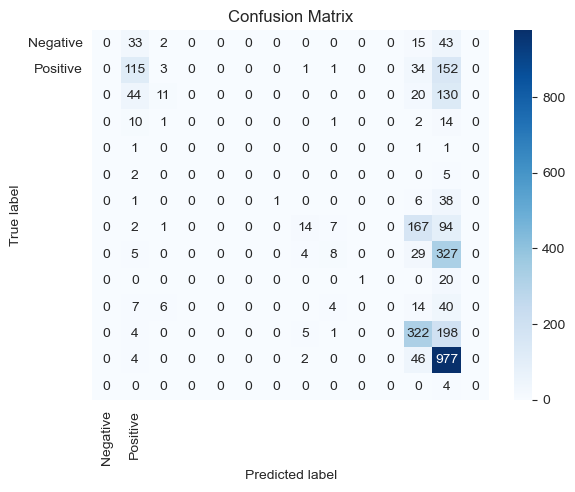

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# make predictions on test data using trained model
y_pred = rf_model.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
